![bookstore](bookstore.jpg)


Identifying popular products is incredibly important for e-commerce companies! Popular products generate more revenue and, therefore, play a key role in stock control.

You've been asked to support an online bookstore by building a model to predict whether a book will be popular or not. They've supplied you with an extensive dataset containing information about all books they've sold, including:

* `price`
* `popularity` (target variable)
* `review/summary`
* `review/text`
* `review/helpfulness`
* `authors`
* `categories`

You'll need to build a model that predicts whether a book will be rated as popular or not.

They have high expectations of you, so have set a target of at least 70% accuracy! You are free to use as many features as you like, and will need to engineer new features to achieve this level of performance.

In [ ]:
# Import some required packages
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# EDA

In [2]:
# Read in the dataset
books = pd.read_csv("data/books.csv")

# Preview the first five rows
books.head()

,title,price,review/helpfulness,review/summary,review/text,description,authors,categories,popularity
0,We Band of Angels: The Untold Story of America...,10.88,2/3,A Great Book about women in WWII,I have alway been a fan of fiction books set i...,"In the fall of 1941, the Philippines was a gar...",'Elizabeth Norman','History',Unpopular
1,Prayer That Brings Revival: Interceding for Go...,9.35,0/0,Very helpful book for church prayer groups and...,Very helpful book to give you a better prayer ...,"In Prayer That Brings Revival, best-selling au...",'Yong-gi Cho','Religion',Unpopular
2,The Mystical Journey from Jesus to Christ,24.95,17/19,Universal Spiritual Awakening Guide With Some ...,The message of this book is to find yourself a...,THE MYSTICAL JOURNEY FROM JESUS TO CHRIST Disc...,'Muata Ashby',"'Body, Mind & Spirit'",Unpopular
3,Death Row,7.99,0/1,Ben Kincaid tries to stop an execution.,The hero of William Bernhardt's Ben Kincaid no...,"Upon receiving his execution date, one of the ...",'Lynden Harris','Social Science',Unpopular
4,Sound and Form in Modern Poetry: Second Editio...,32.50,18/20,good introduction to modern prosody,There's a lot in this book which the reader wi...,An updated and expanded version of a classic a...,"'Harvey Seymour Gross', 'Robert McDowell'",'Poetry',Unpopular


In [3]:
books.price.isnull().sum()

np.int64(0)

<Axes: >

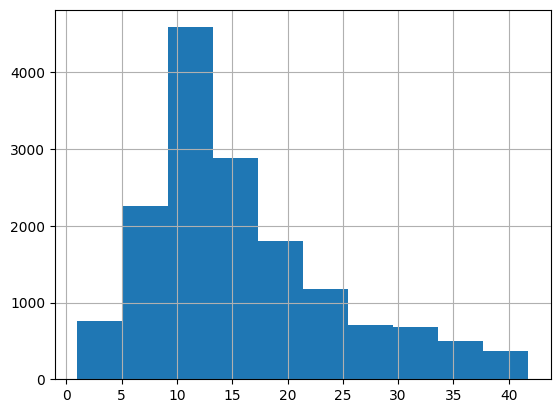

In [4]:

books['price'].hist()

In [5]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15719 entries, 0 to 15718
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               15719 non-null  object 
 1   price               15719 non-null  float64
 2   review/helpfulness  15719 non-null  object 
 3   review/summary      15718 non-null  object 
 4   review/text         15719 non-null  object 
 5   description         15719 non-null  object 
 6   authors             15719 non-null  object 
 7   categories          15719 non-null  object 
 8   popularity          15719 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


In [6]:
# Verify the number of unique values in the 'popularity' column
# This will help us understand the target variable
books['popularity'].unique()

array(['Unpopular', 'Popular'], dtype=object)

In [7]:
# Check the distribution of the title column
books['title'].value_counts()

title
Eldest (Inheritance, Book 2)                                             90
Hannibal                                                                 85
Jane Eyre (Large Print)                                                  70
A Tale of Two Cities - Literary Touchstone Edition                       55
Jane Eyre (New Windmill)                                                 51
                                                                         ..
When God Speaks: How to Interpret Dreams, Visions, Signs and Wonders      1
Parallel Programming in OpenMP                                            1
The Exiles: Chantel (The Creoles, Book 1)                                 1
The Metaphor of God Incarnate                                             1
Organizing to Win: New Research on Union Strategies (Ilr Press Books)     1
Name: count, Length: 6985, dtype: int64

In [8]:
# Check the distribution of the authors column
books['authors'].value_counts()

authors
'Charles Dickens'                                                                                        109
'Christopher Paolini'                                                                                     90
'Thomas Harris'                                                                                           85
'Charlotte Brontë', 'Marc Cactus'                                                                         70
'Charlotte Brontë'                                                                                        51
                                                                                                        ... 
'Gilbert Morris'                                                                                           1
'John Hick'                                                                                                1
'Ira Flatow'                                                                                               1
'Sam Deep',

In [9]:
# Check what are the most popular authors
(books[books['popularity'] == 'Popular']['authors'].value_counts() / books['authors'].value_counts()).fillna(0).sort_values(ascending=False)

authors
"Alfred D'Auberge", 'Morton Manus'                                         1.0
'Kay Pastorius'                                                            1.0
'Ellen Kirschman'                                                          1.0
'Ellen Marshall'                                                           1.0
'Scott Oaks', 'Bernard Traversat', 'Li Gong'                               1.0
                                                                          ... 
'Joachim Engelmann'                                                        0.0
'Joachim Rossberg', 'Rickard Redler'                                       0.0
'Joan Coles', 'Clarence Coles', 'Seloc Publications', 'Nichols / Seloc'    0.0
'Joan Grant'                                                               0.0
'刘珣'                                                                       0.0
Name: count, Length: 6447, dtype: float64

In [10]:
# Check the distribution of the categories column
books['categories'].value_counts().describe()

count     313.000000
mean       50.220447
std       233.359026
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max      3520.000000
Name: count, dtype: float64

In [11]:
books['categories'].unique()

array(["'History'", "'Religion'", "'Body, Mind & Spirit'",
       "'Social Science'", "'Poetry'", "'Music'",
       "'Biography & Autobiography'", "'Science'",
       "'Business & Economics'", "'Fiction'", "'Juvenile Fiction'",
       "'Antiques & Collectibles'", "'Political Science'", "'Travel'",
       "'Nature'", "'Fourth dimension'", "'Computers'",
       "'Health & Fitness'", "'Pets'", "'Self-Help'",
       "'Family & Relationships'", "'Audiobooks'",
       "'Young Adult Fiction'", "'Humor'",
       "'Executions and executioners'", "'Cooking'", "'Transportation'",
       "'Historical fiction'", "'American fiction'",
       "'Comics & Graphic Novels'", "'Games'", "'Law'", "'Psychology'",
       "'Education'", "'Technology & Engineering'", "'Charity-schools'",
       "'Drama'", "'Sports & Recreation'", "'House & Home'",
       "'Juvenile Nonfiction'", "'Games & Activities'", "'Gardening'",
       "'Crafts & Hobbies'", "'Literary Criticism'", "'Photography'",
       "'Philosophy'", "

# Feature Engineering

In [12]:
books_transformed = books.copy()

In [13]:
# Convert review/helpfulness to numeric
books_transformed[['helpful', 'reviews']] = books_transformed['review/helpfulness'].str.split('/', expand=True).astype(int)
books_transformed = books_transformed.drop(columns=['review/helpfulness'])

In [14]:
books_transformed[['authors', 'categories']] = books_transformed[['authors', 'categories']].apply(lambda x: x.str.replace("'", ''))

In [15]:
books_transformed['popularity'] = books_transformed['popularity'].map({'Popular': 1, 'Unpopular': 0})

In [16]:
books_transformed['review/summary'] = books_transformed['review/summary'].apply(
    lambda x: 
    TextBlob(x).sentiment.polarity if isinstance(x, str) else np.nan
)
books_transformed['review/text'] = books_transformed['review/text'].apply(
    lambda x: 
    TextBlob(x).sentiment.polarity if isinstance(x, str) else np.nan
)

In [17]:
books_transformed.head()

,title,price,review/summary,review/text,description,authors,categories,popularity,helpful,reviews
0,We Band of Angels: The Untold Story of America...,10.88,0.80,0.330000,"In the fall of 1941, the Philippines was a gar...",Elizabeth Norman,History,0,2,3
1,Prayer That Brings Revival: Interceding for Go...,9.35,0.20,0.433333,"In Prayer That Brings Revival, best-selling au...",Yong-gi Cho,Religion,0,0,0
2,The Mystical Journey from Jesus to Christ,24.95,0.00,0.001503,THE MYSTICAL JOURNEY FROM JESUS TO CHRIST Disc...,Muata Ashby,"Body, Mind & Spirit",0,17,19
3,Death Row,7.99,-0.10,0.100064,"Upon receiving his execution date, one of the ...",Lynden Harris,Social Science,0,0,1
4,Sound and Form in Modern Poetry: Second Editio...,32.50,0.45,0.166851,An updated and expanded version of a classic a...,"Harvey Seymour Gross, Robert McDowell",Poetry,0,18,20


# Preprocessing

In [18]:
transformer = ColumnTransformer(
    transformers=[
        ('title_tfidf', TfidfVectorizer(stop_words='english'), 'title'),
        ('description_tfidf', TfidfVectorizer(stop_words='english'), 'description'),
        ('authors_tfidf', TfidfVectorizer(token_pattern=r'[^,\n]+', stop_words='english'), 'authors'),
        ('categories_tfidf', TfidfVectorizer(stop_words='english'), 'categories'),
        ('num', StandardScaler(), ['price', 'reviews', 'helpful']),
    ],
    remainder='passthrough'
)

# Model

In [19]:
X = books_transformed.drop(columns=['popularity']).fillna(0)
y = books_transformed['popularity']

In [ ]:
model = LogisticRegression(
    solver='liblinear',
    penalty='l2',
    C=1.,
    max_iter=1000,
    random_state=42
)

In [27]:
pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('classifier', model)
])

# Evaluation

In [33]:
scores = cross_val_score(estimator=pipeline, X=X, y=y, cv=5, scoring='accuracy', n_jobs=-1)

In [34]:
model_accuracy = scores.max()

In [35]:
print(f'Model Accuracy: {model_accuracy:.3f}')

Model Accuracy: 0.761
